# Adversarial examples

V tomto cvičení si vyzkoušíme ošálit natrénovanou konvoluční síť malým pozměněním vstupního obrázku tak, aby výsledné skóre bylo maximální pro nějakou námi zvolenou třídu. Pokud např. neuronová síť správně klasifikuje obrázek automobilu s výstupní pravděpodobností 99 %, cílenou, pro lidské oko však téměř neznatelnou úpravou můžeme dosáhnout 99 % výstupní pravděpodobnosti např. pro třídu jelen.

# Import

In [332]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
from skimage import metrics
import tqdm


import torch
from torchvision import models, transforms

import ans

In [333]:
plt.rcParams['figure.figsize'] = 12., 8.
plt.rcParams['image.interpolation'] = 'nearest'

# Model

Útočit budeme na předtrénovaný model ze ZOO knihovny PyTorch modulu torchvision, který je naučen kasifikovat obrázky databáze ImageNet. Použití modelu z torchvison ZOO je velmi jednoduché. Pokud chceme použít síť s již natrénovanými parametry, stačí do konstruktoru zadat parametr `pretrained=True` a váhy se automaticky stáhnou z repozitáře a uloží do domovského adresáře do podsložky `.torch`. Obvykle se jedná o několik desítek až stovek MB.

In [334]:
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Pokud chceme akcelerovat výpočty na grafické kartě:

In [336]:
model.cuda();

Jelikož model obsahuje vrstvy, které se chovají různě v trénovací a testovací fázi, nesmíme zapomenout přepnout model do testovacího režimu. Jinak může být výstup často nesmyslný, což si ostatně můžete vyzkoušet sami.

In [337]:
model.eval();

Model navíc nebudeme učit a pro zrychlení výpočtu úplně zablokujeme výpočet gradientů na jeho parametry. Síť zde vystupuje jako sice diferencovatelná, ale jinak neměnná funkce.

In [338]:
for par in model.parameters():
    par.requires_grad_(False)

# Data

Data tentokrát potřebovat nebudeme. Stačit nám bude jediný obrázek, např. naše oblíbená žabička.

In [339]:
test_rgb = cv2.imread('./data/happy-green-frog.jpg')[..., ::-1]
test_rgb.dtype, test_rgb.shape

(dtype('uint8'), (500, 500, 3))

In [340]:
plt.imshow(test_rgb)

Všechny modely z torchvision ZOO natrénované na ImageNet na vstupu očekávají RGB obrázky o rozměrech 224 x 224 pixelů. Jelikož budeme potřebovat gradient na vstupní obrázek, bude snazší pracovat s touto velikostí. Ve druhé části cvičení pak toto omezení odstraníte.

In [341]:
test_rgb_small = cv2.resize(test_rgb, (224, 224))
test_rgb_small.dtype, test_rgb_small.shape

(dtype('uint8'), (224, 224, 3))

In [342]:
plt.imshow(test_rgb_small)

ImageNet dělí objetky do 1000 tříd, jejichž názvy si načteme ze souboru. Seznam je volně dostupný [zde](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [343]:
classes = [re.search('[\'"](.+?)[\'"]', l).group(1) for l in open('./data/imagenet1000_clsidx_to_labels.txt')]
print('\n'.join(f'{i}: {c}' for i, c in enumerate(classes)))

0: tench, Tinca tinca
1: goldfish, Carassius auratus
2: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
3: tiger shark, Galeocerdo cuvieri
4: hammerhead, hammerhead shark
5: electric ray, crampfish, numbfish, torpedo
6: stingray
7: cock
8: hen
9: ostrich, Struthio camelus
10: brambling, Fringilla montifringilla
11: goldfinch, Carduelis carduelis
12: house finch, linnet, Carpodacus mexicanus
13: junco, snowbird
14: indigo bunting, indigo finch, indigo bird, Passerina cyanea
15: robin, American robin, Turdus migratorius
16: bulbul
17: jay
18: magpie
19: chickadee
20: water ouzel, dipper
21: kite
22: bald eagle, American eagle, Haliaeetus leucocephalus
23: vulture
24: great grey owl, great gray owl, Strix nebulosa
25: European fire salamander, Salamandra salamandra
26: common newt, Triturus vulgaris
27: eft
28: spotted salamander, Ambystoma maculatum
29: axolotl, mud puppy, Ambystoma mexicanum
30: bullfrog, Rana catesbeiana
31: tree frog, tree-frog
32: 

# Předzpracování obrázku

Všechny modely ze ZOO knihovny torchvision natrénované na ImageNet aplikují na vstupní obrázek shodné úpravy. Kromě normalizace na rozlišení 224 x 224 pixelů se rovněž hodnoty pixelů standardizují vydělením 255, odečtením průměrného RGB pixelu a vydělením standardní odchylkou pro každý kanál zvlášť. Průměrný pixel i standardní odchylka byly vypočteny z celého ImageNetu a jsou pro všechny modely a obrázky společné (jedná se o konstanty).

In [344]:
prep = transforms.Compose([
    transforms.ToTensor(),  # prevede z numpy.ndarray na torch.Tensor a zaroven vydeli 255
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalizuje
])

Abychom mohli upravený obrázek zobrazit, potřebujeme inverzní transformaci, která obrázek vrátí do rozsahů a datových typů vhodných pro matplotlib.

In [345]:
unprep = transforms.Compose([
    lambda x: x.detach().cpu().numpy(),
    lambda x: x.transpose(1, 2, 0),
    lambda x: x * np.array([0.229, 0.224, 0.225]),
    lambda x: x + np.array([0.485, 0.456, 0.406]),
    lambda x: np.uint8(255 * x.clip(0., 1.))
])

# Vstupní tensor

Vyzkoušíme, zdali síť funguje. Funkce `ans.predict_and_show(rgb, model, transform)` vezme obrázek `rgb`, upraví ho transformací `prep` a klasifikuje modelem `model`.

In [346]:
ans.predict_and_show(test_rgb_small, model, prep, classes=classes)

Jak bylo zmíněno, na rozdíl od učení modelu pro klasifikaci tentokrát nebudeme pro dosažení kýženého výstupu upravovat parametry, ale samotný vstup. Musíme proto vytvořit tensor obrázku tak, aby PyTorch věděl, že na něj má počítat gradient. Nejprve však transformujeme standardizujeme odečtením průměru a vydělením odchylkou, jak si to síť "přeje", viz výše.

In [347]:
adv_input_small = prep(np.ascontiguousarray(test_rgb_small))[None]  # `[None]` pro pridani batch dimenze
adv_input_small.shape

torch.Size([1, 3, 224, 224])

Ujistíme se, aby tensor byl ve stejném zařízení (CPU vs GPU), jako je model.

In [348]:
adv_input_small = adv_input_small.to(next(model.parameters()).device)
adv_input_small.device

device(type='cuda', index=0)

Na tensor `adv_input_small` zavoláme metodu `requires_grad_`, jež PyTorchi sdělí, že při zpětném průchodu požadujeme gradient i na tento vstup výpočetního grafu (defaulntě je `False`).

In [349]:
adv_input_small.requires_grad_(True);

# Výstupní skóre a pravděpodobnost

Jak již bylo řečeno, ze sítě dostaneme vektor 1000 skóre pro jednotlivé třídy. Pravděpodobnosti pak získáme jednoduše aplikací softmaxu.

In [350]:
scores = model(adv_input_small)
scores.dtype, scores.shape, scores.min(), scores.max()

(torch.float32,
 torch.Size([1, 1000]),
 tensor(-5.4895, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(20.6068, device='cuda:0', grad_fn=<MaxBackward1>))

In [351]:
softmax = torch.nn.Softmax(dim=1)

In [352]:
probs = softmax(scores)
probs.dtype, probs.shape, probs.min(), probs.max()

(torch.float32,
 torch.Size([1, 1000]),
 tensor(4.6103e-12, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.9937, device='cuda:0', grad_fn=<MaxBackward1>))

# Zadání


Upravte `adv_input_small` tak, aby obrázek byl s alespoň 99% pravděpodobností klasifikován jako libovolná jiná třída. Cílovou kategorii zvolte tak, aby byla vizuálně velmi vzdálená třídám dosahujícím (relativně) vysoké skóre na neupraveném obrázku (tree frog, bullfrog, green lizard, chameleon, ...). Výsledný adversarial obrázek přitom musí zůstat vizuálně téměř nerozeznatelný od původního.

**Postup:**
- síti je třeba nějak sdělit, že na obrázku není `žába`, ale např. `samice hrabáče`
- možností je více:
  - standardní cross entropy loss, kdy správná třída $y$ je nastavena na index třídy `samice hrabáče`
  - bez lossu, kdy zpětný průchod začne až od výstupního skóre (každá tensor v PyTorch implemetuje metodu `backward`), přičemž gradient shora je nastaven na vektor $[-1, -1, \ldots, +1, \ldots, -1]$; tento postup je častější a bude fungovat lépe
- vypočteným gradientem updatujte vstup
  - buď ručně - každá proměnná vytvořená s `requires_grad=True` po zavolání `backward` obsahuje `grad` (pokud tato proměnná je součástí dynamického výpočetního grafu),
  - nebo skrze PyTorch optimizer jako při trénování sítě
- úprava je podobný proces jako trénování sítě, tj. opakujeme uvedené kroky, dokud výstupní pravděpodobnost pro třídu `samice hrabáče` není alespoň 99 %

Výsledek zapište do proměnné `adv_input_small`. Rozdíl $MSE(x, a)$ mezi původním $x$ a upraveným obrázkem $a$ musí být $MSE(x, a) < 1$.

**Pozn.:** Vzhledem ke zaokrouhlovacím chybám a dalším úpravám pravděpodobnost ukazovaná funkcí `ans.predct_and_show` nebude přesně odpovídat pravděpodobnosti ze softmaxu z optimalizačního procesu, ale nejspíše bude o něco málo menší. Nezsavujte proto "učící" proces, hned jak je objeven adversarial obrázek, ale až o chvilku déle.

In [353]:
#################################################################
# ZDE DOPLNIT
# (pridejte libovolny pocet bunek)

In [354]:
gradientt = torch.ones(1, 1000)*(-1)
gradientt = gradientt.to(next(model.parameters()).device)
#767 je tridou 'rubber eraser, rubber, pencil eraser'
predictable_class = 767

while probs[:, predictable_class] < 0.995:
    gradientt[:, predictable_class] = 1
    scores = model(adv_input_small)
    probs = softmax(scores)
    scores.backward(gradientt)
    adv_input_small.data += adv_input_small.grad * 1e-5
        

In [355]:
#################################################################

In [356]:
adv_rgb_small = unprep(adv_input_small.detach()[0])
adv_rgb_small.dtype, adv_rgb_small.shape, adv_rgb_small.min(), adv_rgb_small.max()

(dtype('uint8'), (224, 224, 3), 0, 223)

Predikce na adversarial obrázku:

In [357]:
ans.predict_and_show(adv_rgb_small, model, prep, classes=classes)

Původní, adversarial a jejich rozdíl vedle sebe:

<ipython-input-358-06e2b0c21b51>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.imshow(np.uint8(128 + test_rgb_small.astype(np.float) - adv_rgb_small.astype(np.float)))


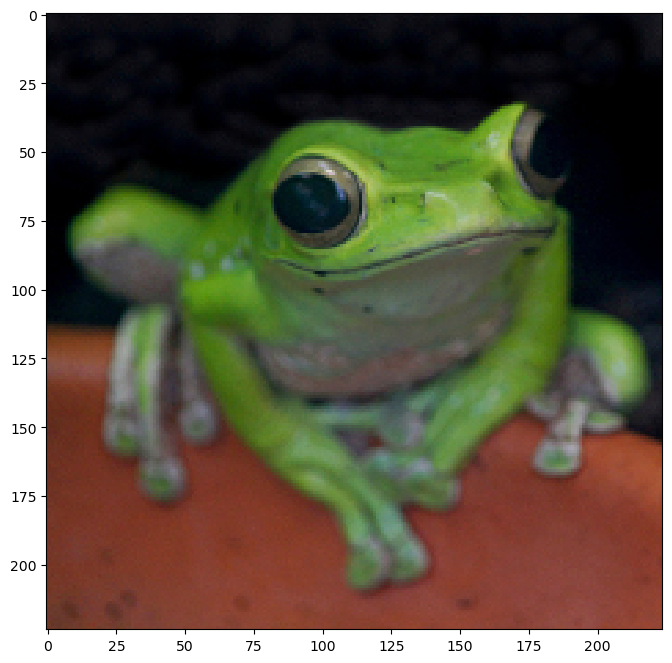

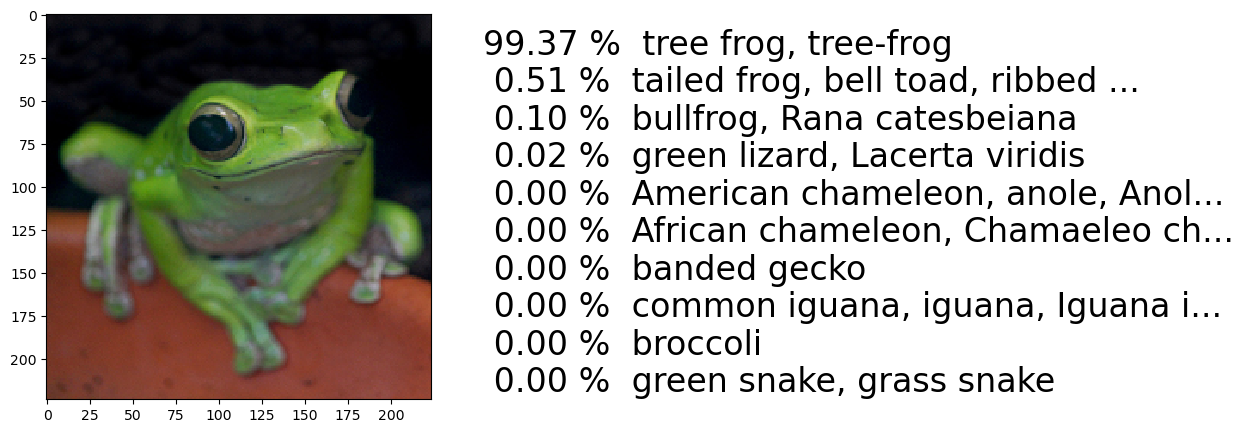

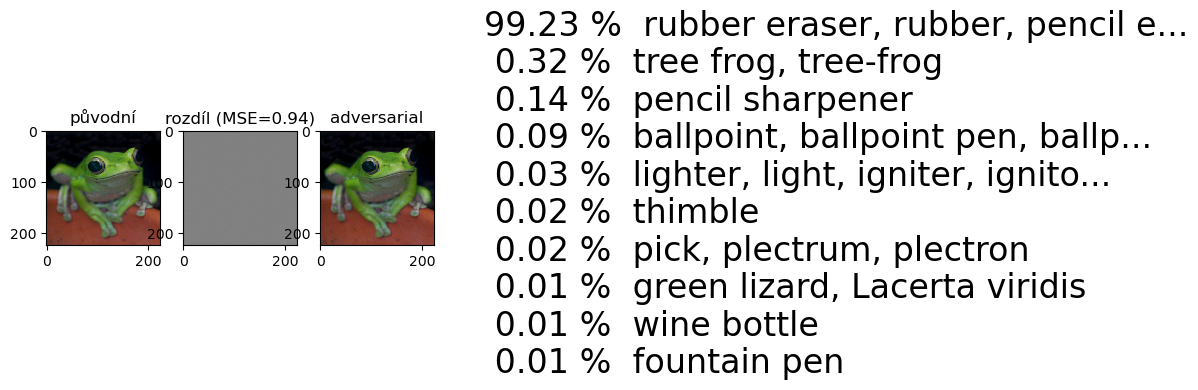

In [358]:
plt.subplot(1, 3, 1)
plt.imshow(test_rgb_small)
plt.title('původní')
plt.subplot(1, 3, 2)
plt.imshow(np.uint8(128 + test_rgb_small.astype(np.float) - adv_rgb_small.astype(np.float)))
plt.title(f'rozdíl (MSE={metrics.mean_squared_error(test_rgb_small, adv_rgb_small):.2f})')
plt.subplot(1, 3, 3)
plt.title('adversarial')
plt.imshow(adv_rgb_small)
plt.show()

## Původní rozlišení

Adversarial lze vytvořit i v původním rozlišení, bez transformace na velikost 224x224 pixelů. Jediné, co k tomu potřebujeme, je nahradit funkci `cv2.resize` diferencovatelnou operací takovou, pro kterou funguje PyTorch autograd pro automatický výpočet gradientu na vstup (backprop). Prohledejte dokumentaci, najděte vhodnou funkci a zopakujte předchozí postup na obrázek v původním rozlišením tj. `test_rgb` (a odpovídající `adv_input`) místo `test_rgb_small` (`adv_input_small`). Výstupem bude `adv_rgb` namísto `adv_rgb_small`.

In [359]:
adv_input = prep(np.ascontiguousarray(test_rgb))[None]

In [360]:
adv_input = adv_input.to(next(model.parameters()).device)
adv_input.device

device(type='cuda', index=0)

In [361]:
adv_input.requires_grad_(True);

In [362]:
#################################################################
# ZDE DOPLNIT
# (pridejte libovolny pocet bunek)

In [363]:
gradientt = torch.ones(1, 1000)*(-1)
gradientt = gradientt.to(next(model.parameters()).device)
#500 je tridou 'cliff dwelling'
predictable_class = 500

while probs[:, predictable_class] < 0.997:
    gradientt[:, predictable_class] = 1
    scores = model(adv_input)
    probs = softmax(scores)
    scores.backward(gradientt)
    adv_input.data += adv_input.grad * 1e-4


In [364]:
#################################################################

In [365]:
adv_rgb = unprep(adv_input.detach()[0])
adv_rgb.shape

(500, 500, 3)

In [367]:
ans.predict_and_show(torch.nn.functional.interpolate(torch.Tensor(adv_rgb)/255, scale_factor=1).detach().numpy(), model, prep, classes=classes)

<ipython-input-368-c9bddeb05d4e>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.imshow(np.uint8(128 + test_rgb.astype(np.float) - adv_rgb.astype(np.float)))


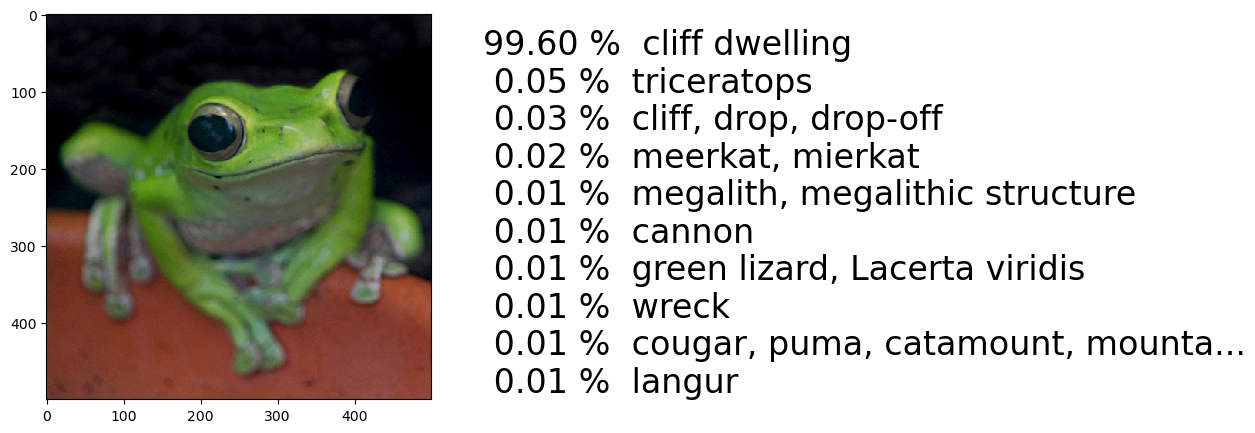

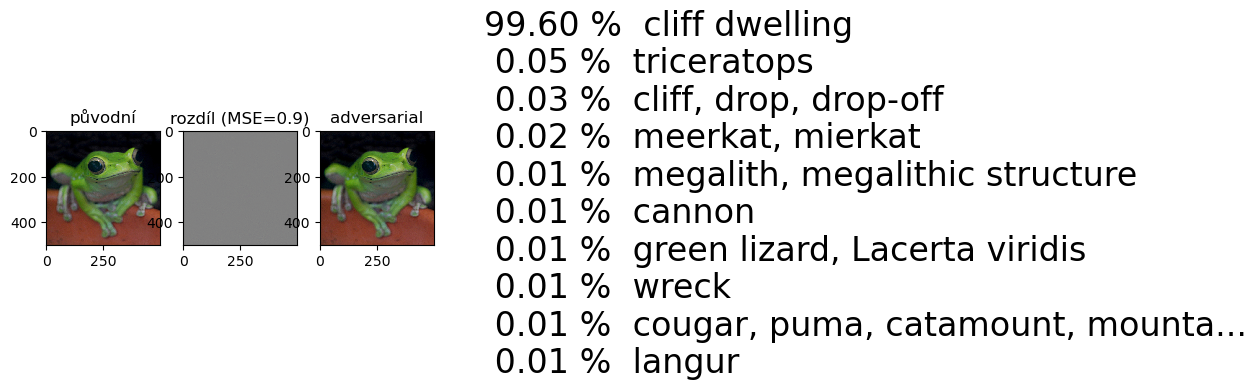

In [368]:
plt.subplot(1, 3, 1)
plt.imshow(test_rgb)
plt.title('původní')
plt.subplot(1, 3, 2)
plt.imshow(np.uint8(128 + test_rgb.astype(np.float) - adv_rgb.astype(np.float)))
plt.title(f'rozdíl (MSE={metrics.mean_squared_error(test_rgb, adv_rgb):.1f})')
plt.subplot(1, 3, 3)
plt.title('adversarial')
plt.imshow(adv_rgb)
plt.show()